By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook analyses the accuracy of affinity predictions when using structures folded by AlphaFold.

In [1]:
# General imports
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading all the test samples (original and predicted with AlphaFold)

In [2]:
modes = 'all'
n_filters = 4
filter_size = 4
pooling_size = 1
n_max_epochs = 935

pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay'] + ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
stage = 'predicting'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

test_pdbs = ['5w1m', '4f3f', '2r56', '3vw3', '6axk', '3eoa', '3bpc', '1yej', '5vzy', '4r8w', '4kht', '2p45', '4rgo', '5cjq', '1tzi', '1a4k', '1m7i', '4u6v', '2i5y', '5w0k', '3o6l']
h_offset_list = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
l_offset_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
original_structures = []
af_pred_structures = []  
    
for test_pdb, h_offset, l_offset, in zip(test_pdbs, h_offset_list, l_offset_list):
    print(test_pdb)
    preprocessed_data = Preprocessing(modes=modes, pathological=pathological, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb, alphafold=False)
    original_structures.append(preprocessed_data.test_x)
    
    preprocessed_data = Preprocessing(modes=modes, pathological=pathological, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb+'_af', alphafold=True, h_offset=h_offset, l_offset=l_offset)
    af_pred_structures.append(preprocessed_data.test_x)
    
input_shape = preprocessed_data.test_x.shape[-1]

5w1m
4f3f
2r56
3vw3
6axk
3eoa
3bpc
1yej
5vzy
4r8w
4kht
2p45
4rgo
5cjq
1tzi
1a4k
1m7i
4u6v
2i5y
5w0k
3o6l


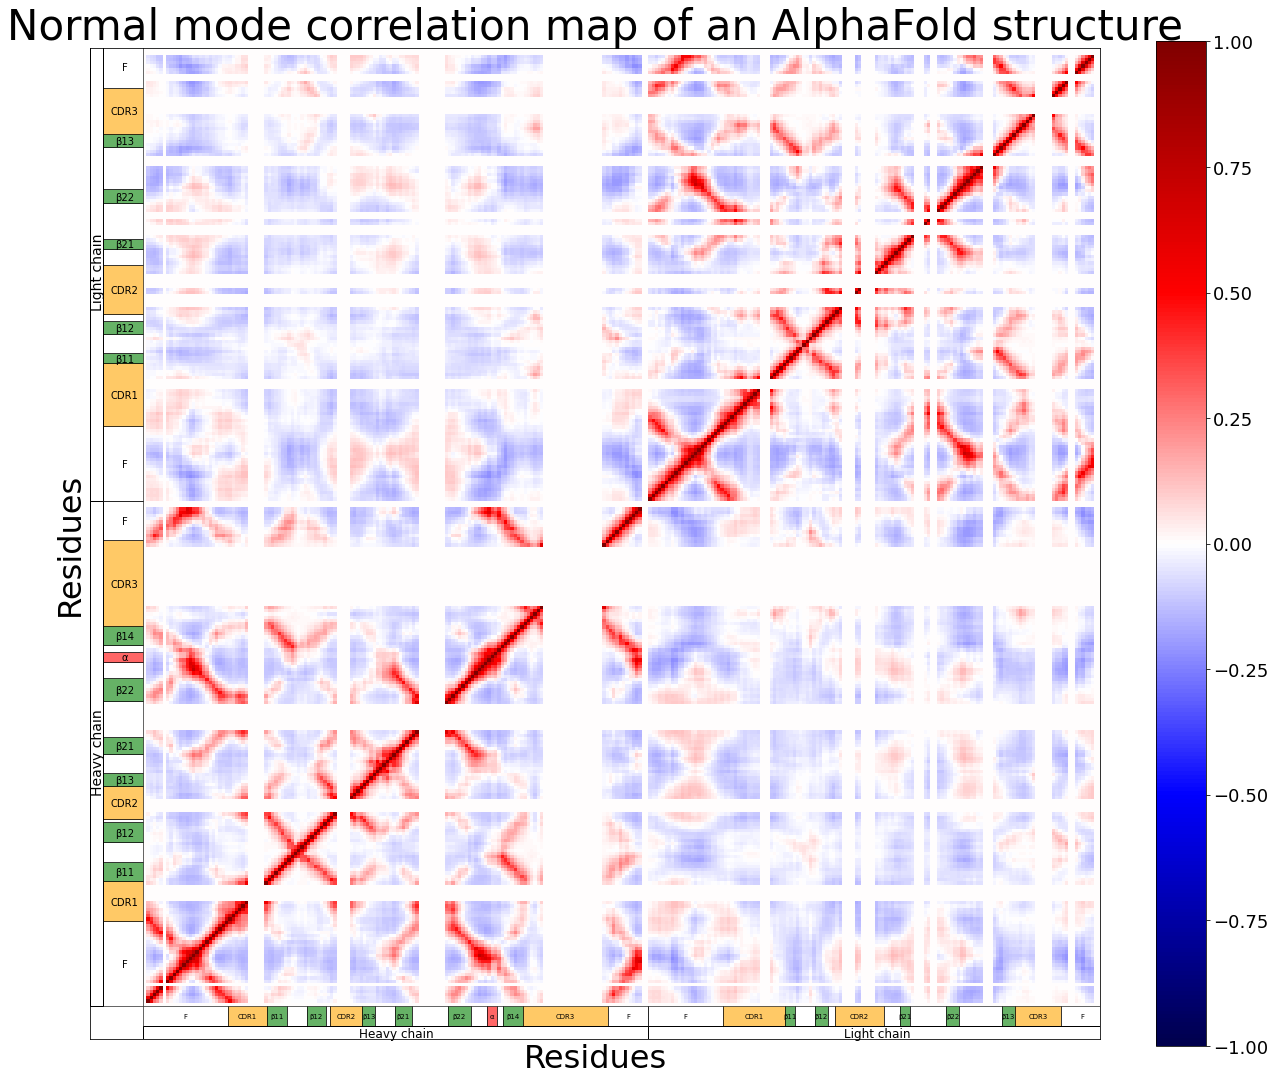

In [3]:
plot_map_with_regions(preprocessed_data, preprocessed_data.test_x, title='Normal mode correlation map of an AlphaFold structure')

# Loading an ANTIPASTI checkpoint

In [4]:
path = '../checkpoints/full_ags_all_modes/seed_13/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
model.eval()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=334084, out_features=1, bias=False)
)

# Predicting the binding affinity

In [5]:
# We convert to the torch format and predict
kds_original = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in original_structures]
kds_af_pred = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in af_pred_structures]
corr_coeff = np.corrcoef(kds_original, kds_af_pred)[1,0]

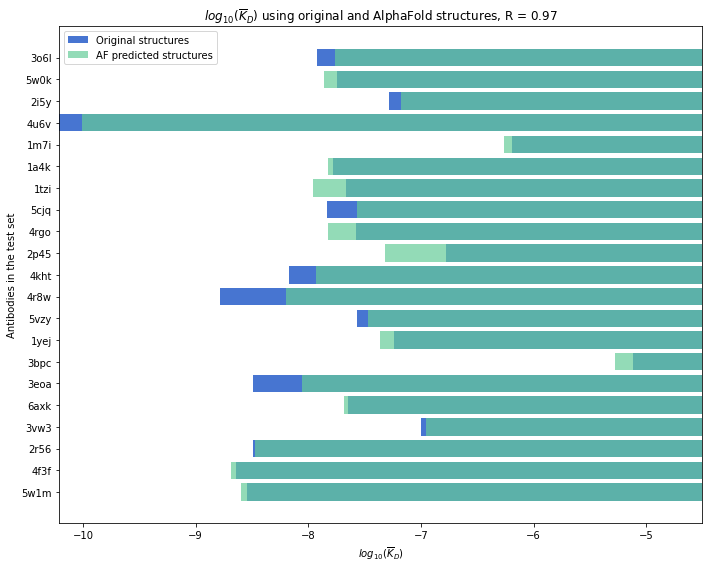

In [6]:
# Horizontal bar chart
fig = plt.figure(figsize=(10, 8))
y_pos = np.arange(len(test_pdbs))
plt.barh(y_pos, kds_original, align='center', alpha=0.9, label='Original structures', color='#3366cc')
plt.barh(y_pos, kds_af_pred, align='center', alpha=0.7, label='AF predicted structures', color='#66cc99')

# Add labels, title, and legend
plt.xlabel('$log_{10}(\overline{K}_D)$')
plt.ylabel('Antibodies in the test set')
plt.title('$log_{10}(\overline{K}_D)$ using original and AlphaFold structures, R = '+str(round(corr_coeff, 2)))
plt.yticks(y_pos, test_pdbs)
plt.legend()
plt.tight_layout()

# x-axis going from the minimum to -4.5
min_kd = min(min(kds_original), min(kds_af_pred))
plt.xlim(min_kd, -4.5)

plt.show()

In [7]:
# Difference of log10(Kd) from original structures and AlphaFold predictions
kds_difference = np.array([kds_original[i] - kds_af_pred[i] for i in range(len(kds_original))])

# Max predicted alignment error (PAE)
af_max_pae = np.array([29.1875, 30.546875, 28.109375, 23.484375, 28.671875, 31.34375, 20.875, 23.78125, 29.984375, 31.578125, 31.234375, 26.9375, 31.5625, 30.84375, 31.546875, 21.25, 20.671875, 31.53125, 31.640625, 31.40625, 26.0625])
af_mean_pae = np.array([4.426376923076923, 3.502604340178686, 4.718328665351742, 3.2568023462828655, 3.203643481882549, 12.740540766733819, 2.3592412827644647, 3.445910004526935, 4.191917333380018, 16.474883693152975, 10.818458259120941, 7.3740316783122815, 12.608831911143566, 10.795276123642791, 11.565669478293808, 2.535208673000881, 2.6607237495549185, 10.322043611687258, 5.822245917355372, 8.242629830611952, 2.774010850577801])
af_max_pae_ab = np.array([29.19, 18.91, 28.11, 23.48, 24.03, 30.34, 20.88, 23.78, 28.31, 30.88, 31.48, 20.62, 31.56, 27.73, 31.55, 21.25, 20.67, 25.83, 31.64, 30.27, 25.11])
af_mean_pae_ab = np.array([3.067827594054726, 2.296170864197531, 3.205357067943021, 3.2568023462828655, 2.5909717656512528, 3.196612192749947, 2.3592412827644647, 3.445910004526935, 2.9207198024691365, 5.824465368945225, 4.164882057931771, 2.9419944444444446, 3.476865842535272, 3.358474541331684, 3.6586974838411823, 2.535208673000881, 2.6607237495549185, 3.358852043248603, 2.853489336911234, 3.5956022799744902, 2.4794398865784504])
af_max_pae_off_blocks = np.array([28.47, 30.55, 23.91, float('nan'), 28.67, 31.34, float('nan'), float('nan'), 29.98, 31.58, 31.41, 26.94, 31.5, 30.84, 31.52, float('nan'), float('nan'), 31.53, 31.56, 31.41, 26.06])
af_mean_pae_off_blocks = np.array([5.915545179971737, 5.387693790849674, 6.445597385337276, float('nan'), 9.67198717948718, 21.95208830664726, float('nan'), float('nan'), 14.260933333333334, 27.663577036688217, 22.3793922852984, 11.96730813172043, 20.846261284032643, 17.655406292894096, 21.80017543859649, float('nan'), float('nan'), 13.606600092719987, 6.933185197155784, 12.468638799317148, 5.190018633540372])
af_max_pae_ab_off_blocks = np.array([29.19, 30.55, 28.11, 23.48, 28.67, 31.34, 20.88, 23.78, 29.98, 31.58, 31.48, 26.94, 31.56, 30.84, 31.55, 21.25, 20.67, 31.53, 31.64, 31.41, 26.06])
af_mean_pae_ab_off_blocks = np.array([4.491686387013232, 3.841932327523603, 4.825477226640149, 3.2568023462828655, 6.131479472569216, 12.574350249698602, 2.3592412827644647, 3.445910004526935, 8.590826567901235, 16.74402120281672, 13.272137171615086, 7.454651288082437, 12.161563563283957, 10.50694041711289, 12.729436461218835,4.386712686638317, 2.9419944444444446, 8.482726067984295, 4.893337267033509, 8.032120539645819, 3.8347292600594116])


# Predicted local distance difference test (pLDDT), i.e., per-residue confidence
# Average of pLDDT
af_plddt = np.array([95.37, 96.12, 94.37, 95.57, 95.40, 87.40, 97.96, 94.14, 91.44, 86.37, 84.57, 92.17, 88.59, 89.35, 88.19, 97.72, 97.48, 87.67, 93.95, 92.90, 97.08])

SignificanceResult(statistic=-0.7037593984962407, pvalue=0.000534935286301242)

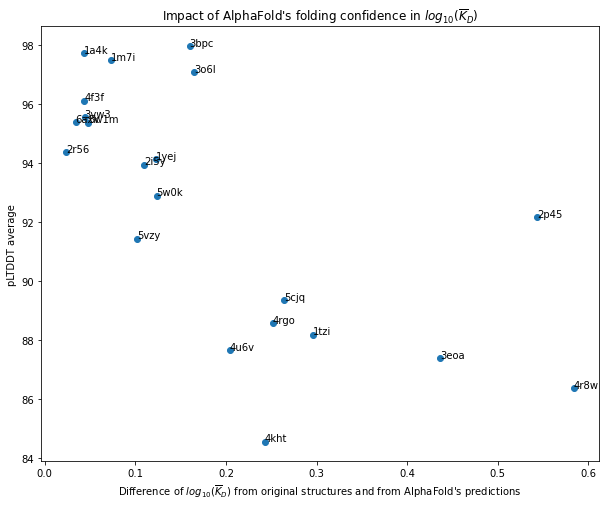

In [24]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_plddt)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('pLTDDT average')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_plddt[i]))
scipy.stats.spearmanr(np.delete(np.abs(kds_difference),11), np.delete(af_plddt,11))

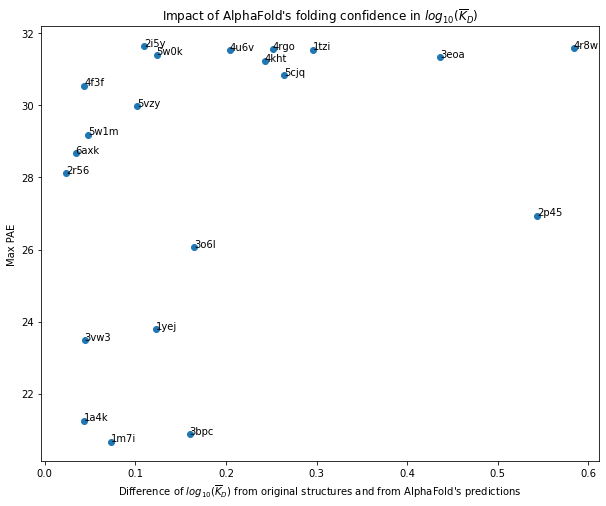

In [9]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae[i]))

SignificanceResult(statistic=0.7037593984962407, pvalue=0.000534935286301242)

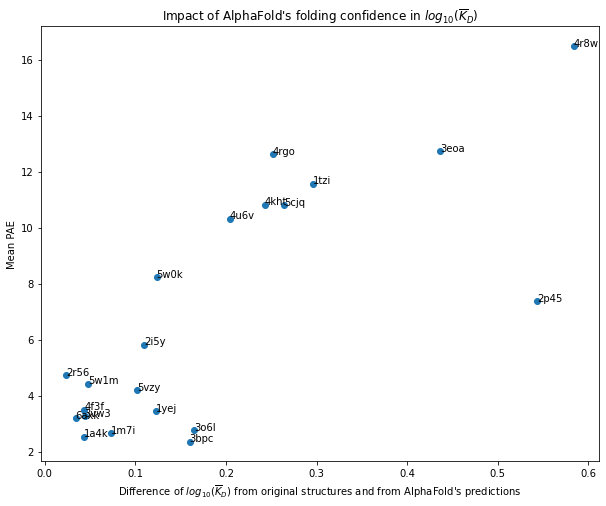

In [18]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae[i]))
scipy.stats.spearmanr(np.delete(np.abs(kds_difference),11), np.delete(af_mean_pae,11))

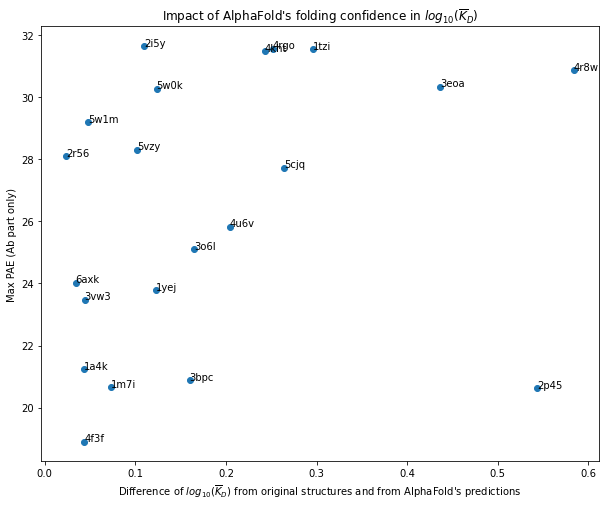

In [11]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae_ab)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE (Ab part only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae_ab[i]))

SignificanceResult(statistic=0.5819548872180451, pvalue=0.00710443754510044)

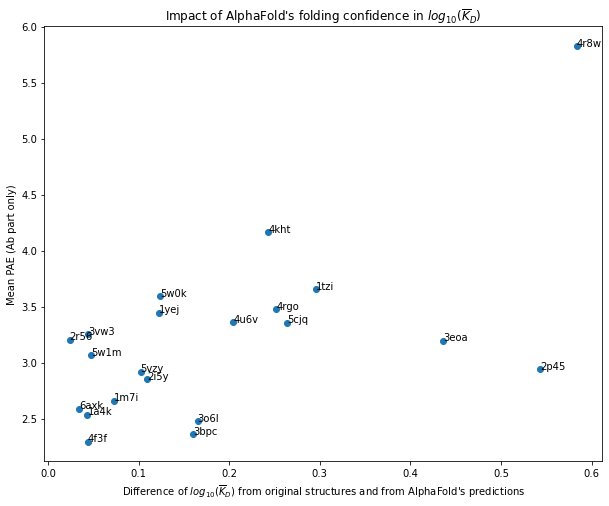

In [12]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae_ab)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE (Ab part only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae_ab[i]))

import scipy
scipy.stats.spearmanr(np.delete(np.abs(kds_difference),11), np.delete(af_mean_pae_ab,11))

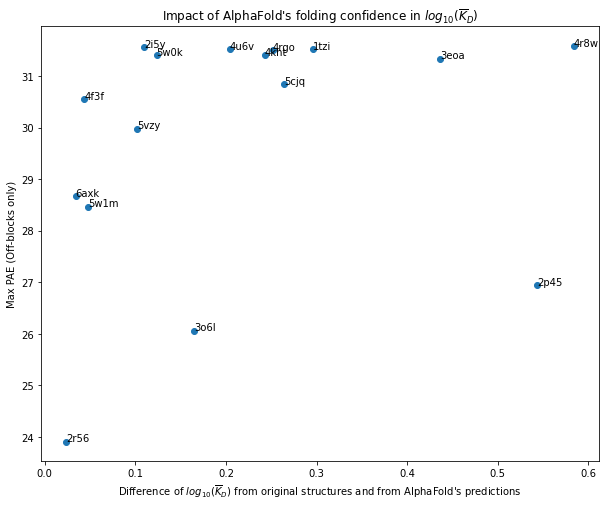

In [13]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae_off_blocks)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE (Off-blocks only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae_off_blocks[i]))

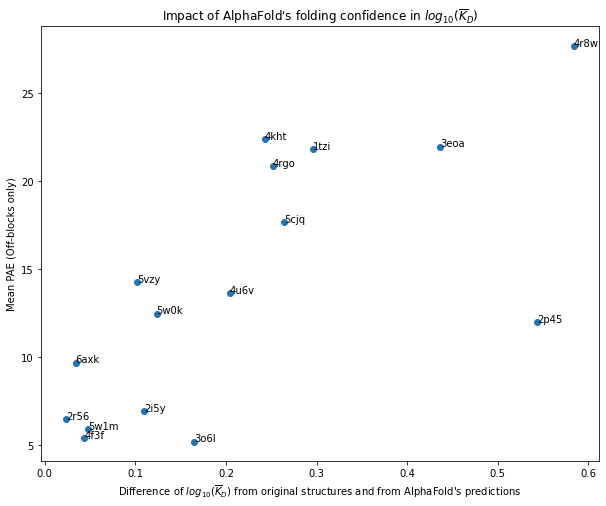

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae_off_blocks)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE (Off-blocks only)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae_off_blocks[i]))

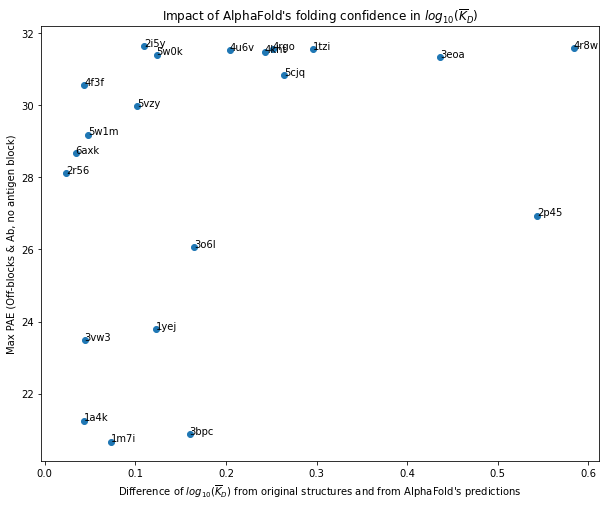

In [15]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_pae_ab_off_blocks)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max PAE (Off-blocks & Ab, no antigen block)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_pae_ab_off_blocks[i]))
    

In [19]:
kds_difference

array([ 0.04743004,  0.04359913, -0.02374935, -0.04402399,  0.03390503,
       -0.43619633,  0.16000652,  0.12265968, -0.10205984, -0.58374405,
       -0.24315214,  0.543231  ,  0.25175667, -0.2643156 ,  0.2960267 ,
        0.04346514,  0.0728693 , -0.20428371, -0.10948181,  0.12342739,
       -0.16520834], dtype=float32)

SignificanceResult(statistic=0.6511278195488721, pvalue=0.0018736439667456594)

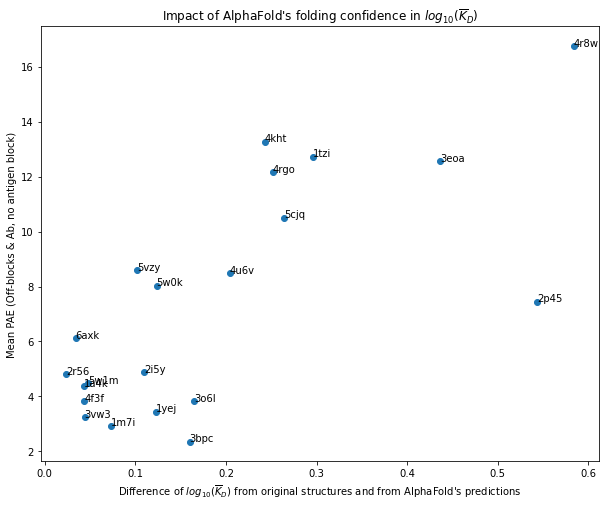

In [22]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_mean_pae_ab_off_blocks)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Mean PAE (Off-blocks & Ab, no antigen block)')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_mean_pae_ab_off_blocks[i]))
scipy.stats.spearmanr(np.delete(np.abs(kds_difference),8), np.delete(af_mean_pae_ab_off_blocks,8))

In [21]:
test_pdbs

['5w1m',
 '4f3f',
 '2r56',
 '3vw3',
 '6axk',
 '3eoa',
 '3bpc',
 '1yej',
 '5vzy',
 '4r8w',
 '4kht',
 '2p45',
 '4rgo',
 '5cjq',
 '1tzi',
 '1a4k',
 '1m7i',
 '4u6v',
 '2i5y',
 '5w0k',
 '3o6l']

In [43]:
#Code to compute Max/Mean of different blocks of PAE matrix

import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

def calculate_metrics(matrix, n):
    # 1. Mean of the error_matrix
    mean_matrix = np.mean(matrix)
    
    # 2. Max of a block 0:n, 0:n
    max_block_ab = np.max(matrix[:n, :n])
    
    # 3. Mean of a block 0:n, 0:n
    mean_block_ab = np.mean(matrix[:n, :n])
    
    # 4. Max of two blocks: 0:n, n:end and n:end, 0:n
    if np.size(matrix[:n, n:]) != 0:
        max_block_offb = np.max([np.max(matrix[:n, n:]), np.max(matrix[n:, :n])])
    else:
        max_block_offb = np.nan
    
    # 5. Mean of two blocks: 0:n, n:end and n:end, 0:n
    mean_block_offb = np.mean([np.mean(matrix[:n, n:]), np.mean(matrix[n:, :n])])
    
    # 6. Max of the block in 2 and the two blocks of 4
    max_combined = np.max([max_block_ab, max_block_offb])
    
    # 7. Mean instead of Max for 6
    mean_combined = np.mean([mean_block_ab, mean_block_offb])
    
    return mean_matrix, max_block_ab, mean_block_ab, max_block_offb, mean_block_offb, max_combined, mean_combined



main_directory = '/Users/kevinmicha/Documents/PhD/Results/AlphaFold results/'

for i, path in enumerate(os.listdir(main_directory)):
    if path not in ['Old', '.DS_Store']:
        with open(glob.glob(os.path.join(main_directory, f'{path}/{path}_scores_rank_001_alphafold2_multimer_v3_model_*_seed_00*.json'))[0], 'r') as json_file:
            data = json.load(json_file)

        # Extract the 'predicted_aligned_error' field
        error_data = data['pae']

        # Convert error_data to a NumPy array for plotting
        error_matrix = np.array(error_data)
        
        with open(main_directory+path+'/'+path+'.csv', 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                sequence = row['sequence']
                break  # We assume there's only one entry in the CSV
        print(path[0:4])
        # Find the index of the first ':' character to determine n
        if path[0:4] == '2p45':
            n = sequence.index(':')
        else:
            second_colon_index = sequence.find(':', sequence.find(':') + 1)
            if second_colon_index == -1:
                n = len(sequence)
            else:
                n = second_colon_index
        if path[0:4] == '4f3f':
            print(error_matrix)
            
        metrics = calculate_metrics(error_matrix, n)

        print(','.join(map(str, metrics)))

        # Create a figure and axis
        #fig, ax = plt.subplots(figsize=(10, 8))

        # Plot the error_matrix using imshow
        #cax = ax.imshow(error_matrix, cmap='viridis', aspect='auto')

        # Add a colorbar
        #cbar = fig.colorbar(cax)

        # Add labels and title
        #plt.xlabel('Position')
        #plt.ylabel('Row')
        #plt.title('Predicted Aligned Error Matrix')

        #plt.tight_layout()
        #plt.show()



5w0k
8.242629830611952,30.27,3.5956022799744902,31.41,12.468638799317148,31.41,8.032120539645819
3o6l
2.774010850577801,25.11,2.4794398865784504,26.06,5.190018633540372,26.06,3.8347292600594116
5cjq
10.795276123642791,27.73,3.358474541331684,30.84,17.655406292894096,30.84,10.50694041711289
4f3f
225
[[ 0.75  0.79  1.26 ... 13.59 14.62 15.93]
 [ 0.77  0.75  0.76 ... 12.29 14.08 15.4 ]
 [ 0.94  0.76  0.75 ... 12.26 14.11 15.42]
 ...
 [24.83 25.64 25.61 ...  0.75  1.69  3.91]
 [27.19 27.77 27.77 ...  1.36  0.75  1.69]
 [28.84 28.98 29.06 ...  4.17  1.49  0.75]]
3.502604340178686,18.91,2.296170864197531,30.55,5.387693790849674,30.55,3.841932327523603
4u6v
10.322043611687258,25.83,3.358852043248603,31.53,13.606600092719987,31.53,8.482726067984295
1yej
3.5487529198732455,27.94,3.5487529198732455,nan,nan,nan,nan
4kht
10.537643320884804,31.38,4.386712686638317,31.08,21.204458118300913,31.38,12.795585402469616
5w1m
4.426376923076923,29.19,3.067827594054726,28.47,5.915545179971737,29.19,4.4916863